In [19]:
import os
import mitsuba as mi
import matplotlib.pyplot as plt
import numpy as np
import colorsys
import json

print(os.path.exists("cube.obj")) 

True


In [20]:
mi.set_variant('llvm_ad_rgb')

scale = 0.28    # cube face length

def light_grid(face, n1, n2, const_val):
    positions = []
    half = scale / 2
    if face == "top":
        xs = np.linspace(-half, half, n1)
        zs = np.linspace(-half, half, n2)
        for x in xs:
            for z in zs:
                positions.append((face, [x, const_val, z]))
    elif face == "back":
        xs = np.linspace(-half, half, n1)
        ys = np.linspace(-half, half, n2)
        for x in xs:
            for y in ys:
                positions.append((face, [x, y, const_val]))
    elif face == "left" or face == "right":
        ys = np.linspace(-half, half, n1)
        zs = np.linspace(-half, half, n2)
        for y in ys:
            for z in zs:
                positions.append((face, [const_val, y, z]))

    return positions


def get_light_color(face, config_name):
    with open('color_configs.json') as f:
        color_configs = json.load(f)

    if config_name not in color_configs:
        raise ValueError(f"Configuration '{config_name}' not found in color_configs.json")
    config = color_configs[config_name]

    color = config.get(face, [0, 0, 0])

    return color

configs = json.load(open("color_configs.json"))
print(configs.keys())


dict_keys(['RGB', 'CMYK', 'GRAY', 'WHITE', 'WARM', 'COOL', 'RAINBOW', 'NEON', 'PASTEL', 'SIDES', 'TOP'])


In [21]:
# 10 x 15 = 150 lights per face

CONST = (scale / 2) + (scale / 5)
left_pos  = light_grid("left",  10, 15, -CONST)  
top_pos   = light_grid("top",   10, 15,  CONST)   
back_pos  = light_grid("back",  10, 15, -CONST)  
right_pos = light_grid("right", 10, 15,  CONST)   

all_pos = left_pos + top_pos + back_pos + right_pos

In [22]:
num_emitters = len(all_pos)
print(f"Number of emitters: {num_emitters}")
emitters = {}

CONFIG = "RGB"

for i, (face, pos) in enumerate(all_pos):
    color = get_light_color(face, CONFIG)
    
    intensity = 0.001


    color = [intensity * c for c in color]
    emitters[f"light_{i}"] = {
        "type": "point",
        "position": pos,
        "intensity": {
            "type": "rgb",
            "value": color
        }
    }

Number of emitters: 600


In [23]:
for key, val in emitters['light_0'].items():
    print( f"{key}: {val}")

def idx_to_face(idx):
    if idx < 150:
        return "left"
    elif idx < 300:
        return "top"
    elif idx < 450:
        return "back"
    elif idx < 600:
        return "right"
    else:
        return None
    
def update_emitters(emitters, translation, scale, orientation, faces_on = ["left", "top", "back", "right"]):
    x, y, z = translation
    s = scale
    x_r, y_r, z_r = orientation

    transform = (
        mi.ScalarTransform4f()
        .translate([x, y, z])
        .rotate([1, 0, 0], x_r)
        .rotate([0, 1, 0], y_r)
        .rotate([0, 0, 1], z_r)
        .scale(s)
    )

    updated_emitters = {}

    for name, light in emitters.items():
        idx = int(name.split("_")[1])
        face = idx_to_face(idx)
        orig_pos = light["position"]
        new_pos = transform @ mi.ScalarPoint3f(orig_pos)

        if face in faces_on: 
            updated_emitters[name] = {
                **light,
                "position": new_pos
            }
        else:
            updated_emitters[name] = {
                **light,
                "position": new_pos,
                "intensity": {
                    "type": "rgb",
                    "value": [0, 0, 0]  # turn off the light
                }
            }

    return updated_emitters





type: point
position: [-0.196, np.float64(-0.14), np.float64(-0.14)]
intensity: {'type': 'rgb', 'value': [0.0, 0.001, 0.0]}


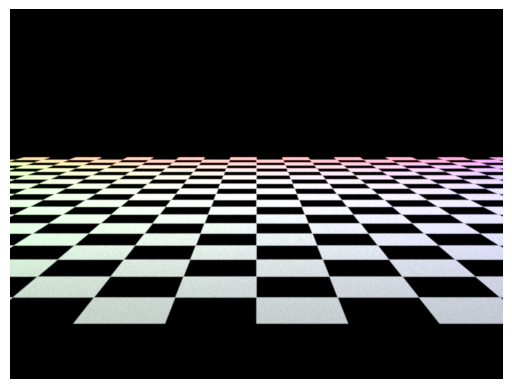

In [25]:

save_path = "./output/night_hdri_mapped.png"

hdri = mi.Bitmap('../night_hdri.exr').convert(mi.Bitmap.PixelFormat.RGB, mi.Struct.Type.Float32)

scene_dict = {
    "type": "scene",
    "integrator": {"type": "path",
                   "hide_emitters": True
                   },
    "sensor": {
        "type": "perspective",
        "sampler": {"type": "independent", "sample_count": 512},
        "to_world": mi.ScalarTransform4f().look_at(
            origin=[0, 0.05, 0.35],
            target=[0, 0, 0],
            up=[0, 1, 0]
        ),
        "film": {
            "type": "hdrfilm",
            "width": 800,
            "height": 600,
            "pixel_format": "rgb"
        },
    },
    # "env": {
    #     "type": "constant",
    #     "radiance": {"type": "rgb", "value": [0.01, 0.01, 0.01]}
    # },
    "env": {
        "type": "envmap",
        "bitmap": hdri,
        "scale": 1.0       # make hdri env light more noticeable
    },

    "checkerboard": {
        "type": "rectangle",
        "to_world": mi.ScalarTransform4f()
            .translate([0, 0, 0])      # Place it on the ground
            .rotate([1, 0, 0], -90)    # Lie flat on XZ
            .scale([0.2, 0.2, 1.0]),  # 20 cm × 20 cm plane
        "bsdf": {
            "type": "diffuse",
            "reflectance": {
                "type": "checkerboard",
                "color0": { "type": "rgb", "value": [1,1,1] },
                "color1": { "type": "rgb", "value": [0,0,0] },
                "to_uv": mi.ScalarTransform4f()
                    .scale([10.0, 10.0, 1.0]) 
            }
        }
    }
}

scene_dict.update(emitters)

scene = mi.load_dict(scene_dict)
img = mi.render(scene)
bitmap = mi.util.convert_to_bitmap(img)

if save_path:
    plt.imshow(bitmap)
    plt.axis('off')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
else:
    plt.imshow(bitmap)
    plt.axis('off')
    plt.show()
